In [6]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [7]:
tox_adata = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox7-full/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
tox_adata_raw = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox7-full/single_cell_objects/filtered.h5ad")

In [8]:
assert tox_adata.obs.index.equals(tox_adata_raw.obs.index)

In [7]:
sc.tl.leiden(tox_adata, resolution=1.25, key_added='leiden')

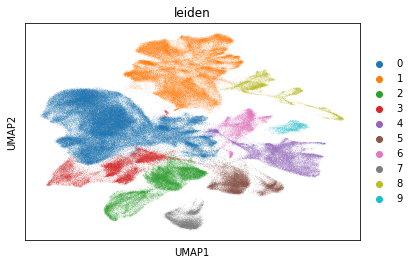

In [10]:
sc.pl.umap(tox_adata, color='leiden')

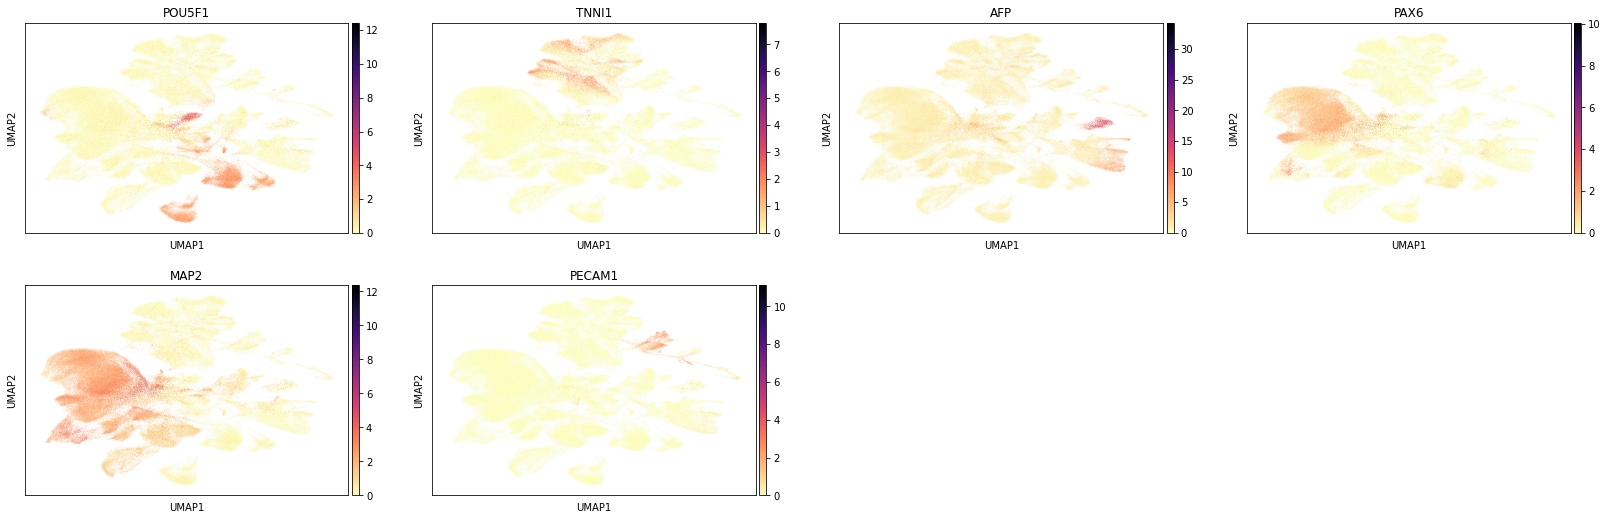

In [12]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'AFP', 'PAX6', 'MAP2', 'PECAM1'], color_map='magma_r')

In [13]:
celltype_labels = {0: 'ectoderm',
                  1: 'mesoderm',
                  2: 'ectoderm',
                  3: 'ectoderm',
                  4: 'endoderm',
                  5: 'pluripotent',
                  6: 'endoderm',
                  7: 'pluripotent',
                  8: 'mesoderm',
                  9: 'endoderm'}

In [14]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [19]:
tox_adata.obs[['treatment_name']].value_counts()

treatment_name 
Metformin          48154
Encainide          46701
Pheniprazine       46139
Norfenfluramine    40957
Pravastatin        40556
Diphenhydramine    34862
Clobutinol         32290
Vancomycin         32000
dtype: int64

In [16]:
treatment_map = {
    'Met': 'Metformin',
    'Enc': 'Encainide', 
    'Phe': 'Pheniprazine',
    'Nor': 'Norfenfluramine',
    'Pra': 'Pravastatin',
    'Dip': 'Diphenhydramine',
    'Clo': 'Clobutinol',
    'Van': 'Vancomycin'
}

In [17]:
tox_adata.obs['treatment_name'] = [treatment_map[t] for t in tox_adata.obs['treatment']]

In [18]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)

/tmp/jobs/31751278/ipykernel_30282/782936707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [20]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<321659x302 sparse matrix of type '<class 'numpy.float64'>'
	with 321659 stored elements in Compressed Sparse Row format>

In [21]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [22]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [23]:
pseudobulk_sum.to_csv("/project/gilad/jpopp/cellcipher/data/Tox7-full/pseudobulk_expression.tsv", sep="\t")

In [24]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment', 'treatment_name']].drop_duplicates()

In [25]:
treatment_dict

,sample_id,treatment,treatment_name
cell,,,
AAACCCAAGCTTAAGA-1,YG-KR-16S-1002-Tox7-10-Dip,Dip,Diphenhydramine
AAACCCAAGAGCCATG-2,YG-KR-16S-1002-Tox7-11-Met,Met,Metformin
AAACCCAAGGGAGATA-3,YG-KR-16S-1002-Tox7-12-Met,Met,Metformin
AAACCCAAGCCGCACT-4,YG-KR-16S-1002-Tox7-6-Pra,Pra,Pravastatin
AAACCCAAGATGACAT-5,YG-KR-16S-1002-Tox7-7-Van,Van,Vancomycin
AAACCCAAGAAATTCG-6,YG-KR-16S-1002-Tox7-9-Dip,Dip,Diphenhydramine
AAACCCAAGGTGTGAC-7,YG-KR-16S-1002-Tox7-1-Nor,Nor,Norfenfluramine
AAACCCAAGAGAGCGG-8,YG-KR-16S-1002-Tox7-8-Van,Van,Vancomycin
AAACCCAAGGCATTTC-9,YG-KR-16S-1002-Tox7-15-Clo,Clo,Clobutinol


In [26]:
treatment_dict.to_csv("/project/gilad/jpopp/cellcipher/data/Tox7-full/treatment_dict.tsv", sep="\t", index=False)